[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RT-DETR on Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2304.08069-b31b1b.svg)](https://arxiv.org/pdf/2304.08069.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/lyuwenyu/RT-DETR)

RT-DETR, short for "Real-Time DEtection TRansformer", is a computer vision model developed by Peking University and Baidu. In their paper, "DETRs Beat YOLOs on Real-time Object Detection" the authors claim that RT-DETR can outperform YOLO models in object detection, both in terms of speed and accuracy. The model has been released under the Apache 2.0 license, making it a great option, especially for enterprise projects.

![RT-DETR Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/rt-detr-figure-1.png)

Recently, RT-DETR was added to the `transformers` library, significantly simplifying its fine-tuning process. In this tutorial, we will show you how to train RT-DETR on a custom dataset.

## Setup

### Configure your API keys

To fine-tune RT-DETR, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Jul  6 05:07:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install dependencies

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━

### Imports

In [4]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

## Inference with pre-trained RT-DETR model

In [5]:
# @title Load model

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
# @title Run inference

URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"

image = Image.open(requests.get(URL, stream=True).raw)
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

## Fine-tune RT-DETR on custom dataset

In [7]:
    rf = Roboflow(api_key="HWbO3PWroeyPMGDv6ISI")
    project = rf.workspace("risetme").project("labeled-mri-brain-tumor-dataset-bfhya")
    version = project.version(1)
    dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Labeled-MRI-Brain-Tumor-Dataset-1 in coco:: 100%|██████████| 2451/2451 [00:01<00:00, 2329.38it/s]


In [8]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 1695
Number of validation images: 502
Number of test images: 246


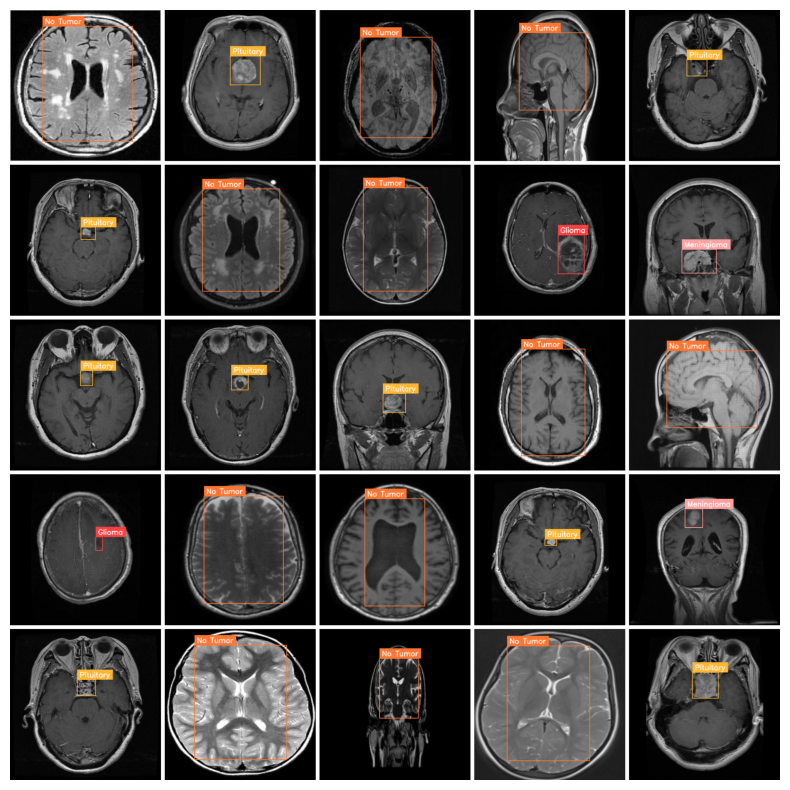

In [9]:
# @title Display dataset sample

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

### Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. [AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and `labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [10]:
IMAGE_SIZE = 640

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

Before passing the images to the `processor`, apply two preprocessing transformations to the dataset:

- Augmenting images
- Reformatting annotations to meet RT-DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/). This library ensures that transformations affect the image and update the bounding boxes accordingly.

In [11]:
train_augmentation_and_transform = A.Compose(
        [
            # Rotation
            A.Rotate(limit=15, p=0.5),

            # Flip (Horizontal dan Vertical)
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),

            # Shear
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=0.1,
                rotate_limit=0,
                shear_limit=15,
                p=0.3
            ),

            # Noise
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
                A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
            ], p=0.3),

            # Brightness (dan Contrast)
            A.RandomBrightnessContrast(
                brightness_limit=0.3,
                contrast_limit=0.3,
                p=0.5
            ),

            # Zoom (Scale)
            A.RandomScale(scale_limit=0.2, p=0.3),

            # Augmentasi tambahan dari kode asli
            A.Perspective(p=0.1),
            A.HueSaturationValue(p=0.1),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["category"],
            clip=True,
            min_area=25
        ),
    )

valid_transform = A.Compose(
        [A.NoOp()],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["category"],
            clip=True,
            min_area=1
        ),
    )

ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
Argument(s) 'shear_limit' are not valid for transform ShiftScaleRotate
Argument(s) 'var_limit' are not valid for transform GaussNoise


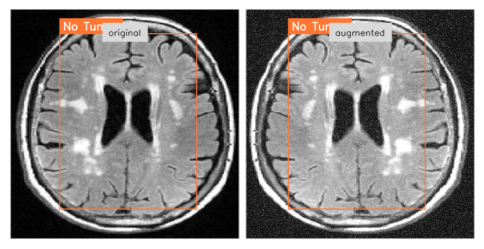

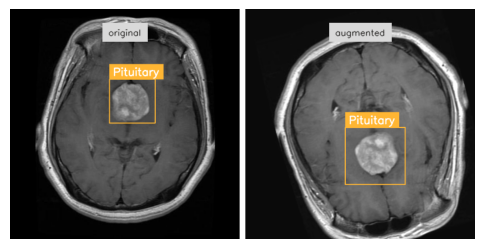

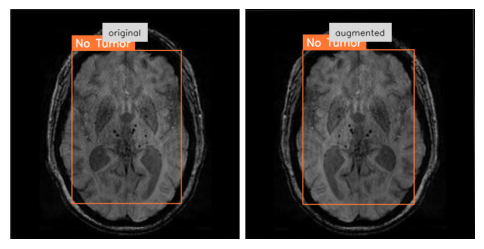

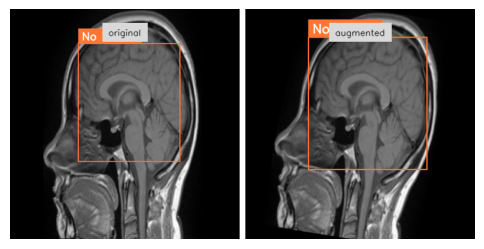

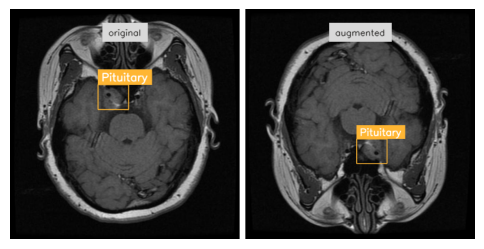

In [12]:
# @title Visualize some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

The `processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`, where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [13]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

Now you can combine the image and annotation transformations to use on a batch of examples:

In [14]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275]],
 
         [[0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275]],
 
         [[0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.027

You have successfully augmented the images and prepared their annotations. In the final step, create a custom collate_fn to batch images together.

In [15]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

## Preparing function to compute mAP

In [16]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

- Load the model with [`AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
- Define your training hyperparameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
- Pass the training arguments to [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
- Call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id` and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [17]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.

In the [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit. For `num_train_epochs=10` training will take about 15 minutes in Google Colab T4 GPU, increase the number of epoch to get better results.

Important notes:

- Do not remove unused columns because this will drop the image column. Without the image column, you can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
- Set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated we will not be able to determine which boxes belongs to particular image.

In [18]:
training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=20,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

Finally, bring everything together, and call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andrirahmadani011202 (andrirahmadani) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Tumor-vr5s,Mar 100 Tumor-vr5s,Map Glioma,Mar 100 Glioma,Map Meningioma,Mar 100 Meningioma,Map No tumor,Mar 100 No tumor,Map Pituitary,Mar 100 Pituitary
1,No log,78.360405,0.011800,0.052300,0.001400,-1.000000,0.005400,0.012400,0.062600,0.143000,0.159600,-1.000000,0.077700,0.194900,-1.000000,-1.000000,0.004000,0.132500,0.001600,0.092000,0.040800,0.291900,0.000900,0.122000
2,No log,28.790043,0.084800,0.222700,0.043400,-1.000000,0.100200,0.085000,0.243300,0.408600,0.440600,-1.000000,0.378700,0.486300,-1.000000,-1.000000,0.080600,0.393300,0.018100,0.376000,0.082000,0.447500,0.158300,0.545800
3,No log,21.054373,0.115500,0.330400,0.035700,-1.000000,0.098900,0.125500,0.333100,0.514200,0.566900,-1.000000,0.502900,0.601600,-1.000000,-1.000000,0.153200,0.528200,0.027400,0.580000,0.162500,0.568700,0.118900,0.590700
4,No log,16.753458,0.157100,0.400100,0.070600,-1.000000,0.166000,0.147300,0.378800,0.559500,0.612200,-1.000000,0.516500,0.663500,-1.000000,-1.000000,0.096800,0.518400,0.045800,0.638400,0.194400,0.676800,0.291300,0.615300
5,58.996800,15.416493,0.216800,0.529800,0.112400,-1.000000,0.183800,0.237200,0.408400,0.577200,0.637300,-1.000000,0.549300,0.684300,-1.000000,-1.000000,0.226700,0.547200,0.094600,0.654400,0.287000,0.707100,0.258900,0.640700
6,58.996800,14.753103,0.220700,0.547500,0.108600,-1.000000,0.202300,0.238700,0.419800,0.597600,0.648900,-1.000000,0.583000,0.699000,-1.000000,-1.000000,0.208400,0.582800,0.048400,0.694400,0.300400,0.688900,0.325800,0.629700
7,58.996800,14.188951,0.235600,0.551500,0.135700,-1.000000,0.212000,0.257900,0.427700,0.602400,0.629200,-1.000000,0.540300,0.686400,-1.000000,-1.000000,0.202000,0.532500,0.092200,0.656800,0.309000,0.696000,0.339200,0.631400
8,58.996800,14.017584,0.250300,0.580200,0.148000,-1.000000,0.213100,0.278000,0.437100,0.604900,0.649100,-1.000000,0.576300,0.704400,-1.000000,-1.000000,0.237300,0.595100,0.042300,0.680800,0.394500,0.722200,0.327200,0.598300
9,58.996800,13.521263,0.292000,0.625200,0.215200,-1.000000,0.239500,0.319600,0.465500,0.621900,0.659500,-1.000000,0.584000,0.705100,-1.000000,-1.000000,0.223800,0.580400,0.075400,0.683200,0.467100,0.736400,0.401700,0.638100
10,13.751400,13.269809,0.308800,0.639300,0.253500,-1.000000,0.253500,0.349900,0.496200,0.624700,0.669900,-1.000000,0.590100,0.713200,-1.000000,-1.000000,0.274100,0.597500,0.078600,0.680800,0.458000,0.738400,0.424300,0.662700


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

TrainOutput(global_step=2120, training_loss=23.188214514390477, metrics={'train_runtime': 6242.5312, 'train_samples_per_second': 5.43, 'train_steps_per_second': 0.34, 'total_flos': 1.068127471706112e+19, 'train_loss': 23.188214514390477, 'epoch': 20.0})

## Evaluate

In [20]:
# @title Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [21]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.34
map50: 0.63
map75: 0.33


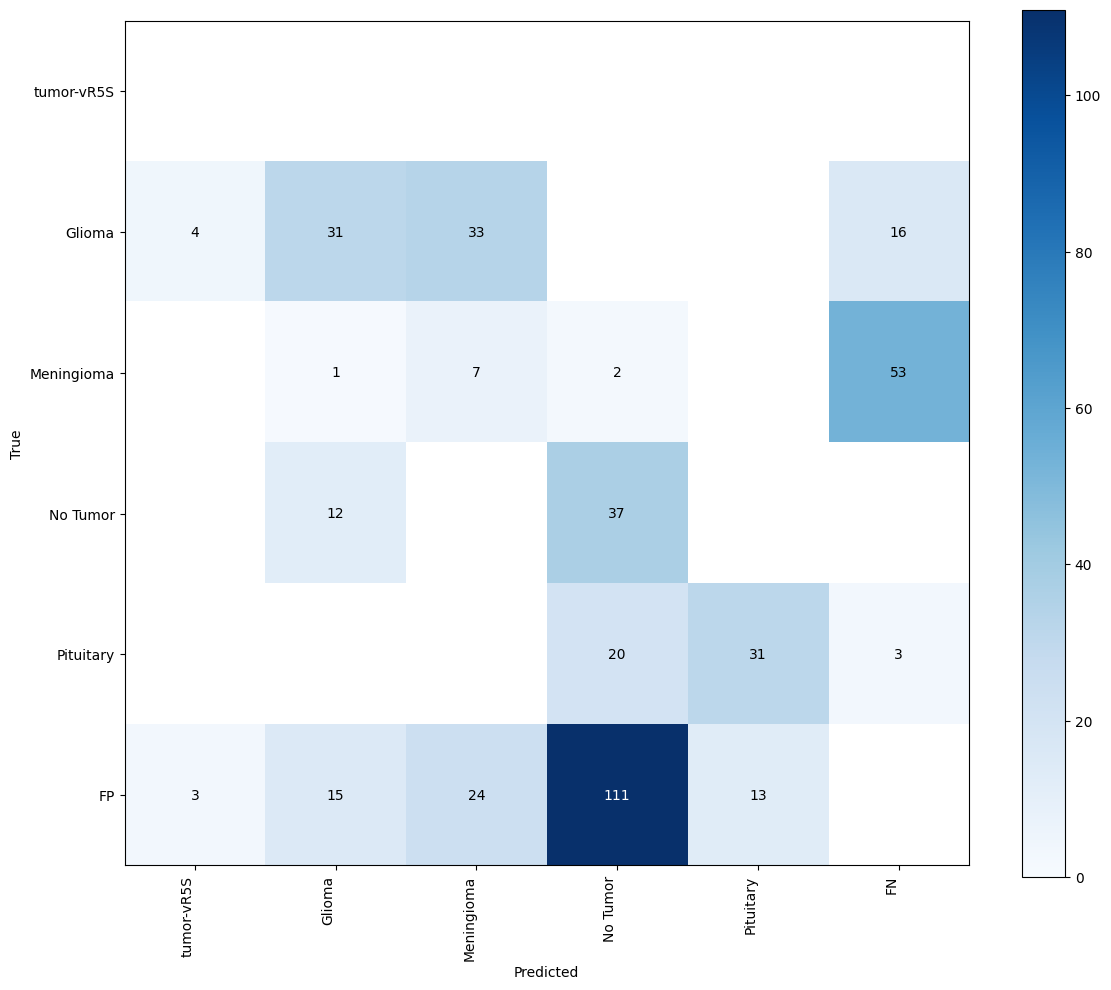

In [22]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [23]:
model.save_pretrained("/content/rt-detr/")
processor.save_pretrained("/content/rt-detr/")

['/content/rt-detr/preprocessor_config.json']

In [26]:
# prompt: buatkan zip
# model.save_pretrained("/content/rt-detr/")
# processor.save_pretrained("/content/rt-detr/")

!zip -r /content/rt-detr.zip /content/rt-detr/

  adding: content/rt-detr/ (stored 0%)
  adding: content/rt-detr/model.safetensors (deflated 7%)
  adding: content/rt-detr/config.json (deflated 63%)
  adding: content/rt-detr/preprocessor_config.json (deflated 46%)


## Inference with fine-tuned RT-DETR model

In [ ]:
IMAGE_COUNT = 30

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv
from typing import List, Tuple, Dict, Any
import cv2


class AdversarialAttack:
    """
    Base class untuk adversarial attacks pada RT-DETR model
    """

    def __init__(self, model, processor, device='cuda'):
        """
        Args:
            model: RT-DETR model yang sudah di-load
            processor: Image processor untuk preprocessing
            device: Device yang digunakan (cuda/cpu)
        """
        self.model = model
        self.processor = processor
        self.device = device
        self.model.eval()

    def preprocess_image(self, image):
        """
        Preprocess image untuk model
        """
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        inputs = self.processor(image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(self.device)
        return pixel_values

    def postprocess_outputs(self, outputs, image_size):
        """
        Post-process model outputs
        """
        h, w = image_size
        results = self.processor.post_process_object_detection(
            outputs, target_sizes=[(h, w)], threshold=0.3
        )
        return results

    def calculate_loss(self, outputs, targets):
        """
        Calculate loss untuk adversarial attack
        Menggunakan detection loss yang sesuai dengan RT-DETR
        """
        # Untuk RT-DETR, kita bisa menggunakan sum of logits sebagai loss
        # atau custom loss function berdasarkan detection task
        if hasattr(outputs, 'logits'):
            # Menggunakan maksimum confidence sebagai loss
            loss = -torch.max(outputs.logits)
        else:
            # Fallback: menggunakan sum dari semua predictions
            loss = -torch.sum(outputs.pred_boxes) - torch.sum(outputs.logits)

        return loss

    def denormalize_image(self, tensor_image):
        """
        Denormalize image tensor untuk visualisasi
        """
        # Detach tensor terlebih dahulu
        tensor_image = tensor_image.detach()

        # Asumsi normalisasi standar ImageNet
        mean = torch.tensor([0.485, 0.456, 0.406]).to(self.device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(self.device)

        # Denormalize
        denorm = tensor_image * std.view(3, 1, 1) + mean.view(3, 1, 1)
        denorm = torch.clamp(denorm, 0, 1)

        return denorm

    def tensor_to_image(self, tensor_image):
        """
        Convert tensor ke PIL Image
        """
        # Detach tensor dari computational graph
        tensor_image = tensor_image.detach()

        # Denormalize jika diperlukan
        if tensor_image.min() < 0:
            tensor_image = self.denormalize_image(tensor_image)

        # Convert ke numpy
        numpy_image = tensor_image.squeeze().cpu().numpy()
        numpy_image = np.transpose(numpy_image, (1, 2, 0))
        numpy_image = (numpy_image * 255).astype(np.uint8)

        return Image.fromarray(numpy_image)


class FGSM(AdversarialAttack):
    """
    Fast Gradient Sign Method (FGSM) Attack
    """

    def __init__(self, model, processor, device='cuda'):
        super().__init__(model, processor, device)

    def generate_adversarial(self, image, epsilon=0.03, targeted=False, target_class=None):
        """
        Generate adversarial example menggunakan FGSM

        Args:
            image: Input image (PIL Image atau numpy array)
            epsilon: Perturbation magnitude
            targeted: Whether to perform targeted attack
            target_class: Target class untuk targeted attack

        Returns:
            adversarial_image: Adversarial image
            perturbation: Perturbation yang ditambahkan
            original_prediction: Prediksi asli
            adversarial_prediction: Prediksi adversarial
        """
        # Preprocess image
        original_image = image.copy() if hasattr(image, 'copy') else image
        pixel_values = self.preprocess_image(image)
        pixel_values.requires_grad_(True)

        # Forward pass untuk mendapatkan prediksi asli
        with torch.enable_grad():
            outputs = self.model(pixel_values)
            original_prediction = self.postprocess_outputs(outputs, image.size if hasattr(image, 'size') else (image.shape[0], image.shape[1]))

        # Calculate loss
        if targeted and target_class is not None:
            # Untuk targeted attack, minimize loss untuk target class
            loss = -self.calculate_loss(outputs, target_class)
        else:
            # Untuk untargeted attack, maximize loss
            loss = self.calculate_loss(outputs, None)

        # Backward pass
        loss.backward()

        # Generate perturbation
        data_grad = pixel_values.grad.data
        sign_data_grad = data_grad.sign()

        # Create adversarial example
        adversarial_pixel_values = pixel_values + epsilon * sign_data_grad
        adversarial_pixel_values = torch.clamp(adversarial_pixel_values, 0, 1)

        # Forward pass pada adversarial example
        with torch.no_grad():
            adversarial_outputs = self.model(adversarial_pixel_values)
            adversarial_prediction = self.postprocess_outputs(
                adversarial_outputs,
                image.size if hasattr(image, 'size') else (image.shape[0], image.shape[1])
            )

        # Convert ke image
        adversarial_image = self.tensor_to_image(adversarial_pixel_values.detach())
        perturbation = self.tensor_to_image((epsilon * sign_data_grad).detach())

        return {
            'adversarial_image': adversarial_image,
            'perturbation': perturbation,
            'original_prediction': original_prediction,
            'adversarial_prediction': adversarial_prediction,
            'epsilon': epsilon
        }


class PGD(AdversarialAttack):
    """
    Projected Gradient Descent (PGD) Attack
    """

    def __init__(self, model, processor, device='cuda'):
        super().__init__(model, processor, device)

    def generate_adversarial(self, image, epsilon=0.03, alpha=0.01, num_iter=10, targeted=False, target_class=None):
        """
        Generate adversarial example menggunakan PGD

        Args:
            image: Input image (PIL Image atau numpy array)
            epsilon: Maximum perturbation magnitude
            alpha: Step size
            num_iter: Number of iterations
            targeted: Whether to perform targeted attack
            target_class: Target class untuk targeted attack

        Returns:
            adversarial_image: Adversarial image
            perturbation: Perturbation yang ditambahkan
            original_prediction: Prediksi asli
            adversarial_prediction: Prediksi adversarial
        """
        # Preprocess image
        original_image = image.copy() if hasattr(image, 'copy') else image
        pixel_values = self.preprocess_image(image)
        original_pixel_values = pixel_values.clone()

        # Forward pass untuk mendapatkan prediksi asli
        with torch.no_grad():
            outputs = self.model(pixel_values)
            original_prediction = self.postprocess_outputs(outputs, image.size if hasattr(image, 'size') else (image.shape[0], image.shape[1]))

        # Initialize adversarial example dengan random noise
        adversarial_pixel_values = pixel_values.clone()
        adversarial_pixel_values = adversarial_pixel_values + torch.empty_like(adversarial_pixel_values).uniform_(-epsilon, epsilon)
        adversarial_pixel_values = torch.clamp(adversarial_pixel_values, 0, 1)

        # PGD iterations
        for i in range(num_iter):
            adversarial_pixel_values.requires_grad_(True)

            # Forward pass
            outputs = self.model(adversarial_pixel_values)

            # Calculate loss
            if targeted and target_class is not None:
                # Untuk targeted attack, minimize loss untuk target class
                loss = -self.calculate_loss(outputs, target_class)
            else:
                # Untuk untargeted attack, maximize loss
                loss = self.calculate_loss(outputs, None)

            # Backward pass
            loss.backward()

            # Update adversarial example
            data_grad = adversarial_pixel_values.grad.data
            adversarial_pixel_values = adversarial_pixel_values + alpha * data_grad.sign()

            # Project ke epsilon ball
            perturbation = adversarial_pixel_values - original_pixel_values
            perturbation = torch.clamp(perturbation, -epsilon, epsilon)
            adversarial_pixel_values = original_pixel_values + perturbation
            adversarial_pixel_values = torch.clamp(adversarial_pixel_values, 0, 1)

            # Detach untuk iterasi selanjutnya
            adversarial_pixel_values = adversarial_pixel_values.detach()

        # Forward pass pada adversarial example final
        with torch.no_grad():
            adversarial_outputs = self.model(adversarial_pixel_values)
            adversarial_prediction = self.postprocess_outputs(
                adversarial_outputs,
                image.size if hasattr(image, 'size') else (image.shape[0], image.shape[1])
            )

        # Convert ke image
        adversarial_image = self.tensor_to_image(adversarial_pixel_values.detach())
        perturbation_img = self.tensor_to_image((adversarial_pixel_values - original_pixel_values).detach())

        return {
            'adversarial_image': adversarial_image,
            'perturbation': perturbation_img,
            'original_prediction': original_prediction,
            'adversarial_prediction': adversarial_prediction,
            'epsilon': epsilon,
            'alpha': alpha,
            'num_iter': num_iter
        }


class AdversarialEvaluator:
    """
    Class untuk evaluasi robustness model terhadap adversarial attacks
    """

    def __init__(self, model, processor, device='cuda'):
        self.model = model
        self.processor = processor
        self.device = device
        self.fgsm = FGSM(model, processor, device)
        self.pgd = PGD(model, processor, device)

    def evaluate_robustness(self, test_dataset, epsilon_values=[0.01, 0.03, 0.05, 0.1],
                          attack_methods=['fgsm', 'pgd'], num_samples=None):
        """
        Evaluate robustness model terhadap berbagai serangan adversarial

        Args:
            test_dataset: Dataset untuk evaluasi
            epsilon_values: List nilai epsilon untuk diuji
            attack_methods: List metode serangan
            num_samples: Jumlah sample untuk evaluasi (None untuk semua)

        Returns:
            results: Dictionary berisi hasil evaluasi
        """
        results = {
            'clean_accuracy': 0,
            'adversarial_accuracy': {},
            'map_scores': {},
            'detailed_results': []
        }

        # Tentukan jumlah sample
        total_samples = len(test_dataset) if num_samples is None else min(num_samples, len(test_dataset))

        # Evaluasi pada clean data
        clean_predictions = []
        clean_targets = []

        for i in range(total_samples):
            path, source_image, annotations = test_dataset[i]
            image = Image.open(path)

            # Prediksi clean
            inputs = self.processor(image, return_tensors="pt").to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)

            w, h = image.size
            results_clean = self.processor.post_process_object_detection(
                outputs, target_sizes=[(h, w)], threshold=0.3
            )

            detections = sv.Detections.from_transformers(results_clean[0])
            clean_predictions.append(detections)
            clean_targets.append(annotations)

        # Hitung mAP untuk clean data
        clean_map = sv.MeanAveragePrecision.from_detections(
            predictions=clean_predictions,
            targets=clean_targets,
        )
        results['clean_accuracy'] = clean_map.map50_95
        results['map_scores']['clean'] = {
            'map50_95': clean_map.map50_95,
            'map50': clean_map.map50,
            'map75': clean_map.map75
        }

        # Evaluasi adversarial attacks
        for attack_method in attack_methods:
            results['adversarial_accuracy'][attack_method] = {}
            results['map_scores'][attack_method] = {}

            for epsilon in epsilon_values:
                adversarial_predictions = []
                adversarial_targets = []

                for i in range(total_samples):
                    path, source_image, annotations = test_dataset[i]
                    image = Image.open(path)

                    # Generate adversarial example
                    if attack_method == 'fgsm':
                        attack_result = self.fgsm.generate_adversarial(image, epsilon=epsilon)
                    elif attack_method == 'pgd':
                        attack_result = self.pgd.generate_adversarial(image, epsilon=epsilon)

                    # Ambil prediksi adversarial
                    adversarial_pred = attack_result['adversarial_prediction']
                    detections = sv.Detections.from_transformers(adversarial_pred[0])

                    adversarial_predictions.append(detections)
                    adversarial_targets.append(annotations)

                # Hitung mAP untuk adversarial data
                adversarial_map = sv.MeanAveragePrecision.from_detections(
                    predictions=adversarial_predictions,
                    targets=adversarial_targets,
                )

                results['adversarial_accuracy'][attack_method][epsilon] = adversarial_map.map50_95
                results['map_scores'][attack_method][epsilon] = {
                    'map50_95': adversarial_map.map50_95,
                    'map50': adversarial_map.map50,
                    'map75': adversarial_map.map75
                }

        return results

    def visualize_attacks(self, image, epsilon_values=[0.01, 0.03, 0.05],
                         attack_methods=['fgsm', 'pgd'], classes=None):
        """
        Visualisasi hasil serangan adversarial

        Args:
            image: Input image
            epsilon_values: List nilai epsilon
            attack_methods: List metode serangan
            classes: List nama class untuk labeling
        """
        fig, axes = plt.subplots(len(attack_methods), len(epsilon_values) + 1,
                                figsize=(4 * (len(epsilon_values) + 1), 4 * len(attack_methods)))

        if len(attack_methods) == 1:
            axes = axes.reshape(1, -1)

        def annotate_image(img, predictions, classes):
            """Helper function untuk annotate image"""
            if len(predictions) > 0:
                detections = sv.Detections.from_transformers(predictions[0])

                # Annotate
                bounding_box_annotator = sv.BoxAnnotator()
                label_annotator = sv.LabelAnnotator(text_scale=0.5, text_thickness=1)

                annotated_img = np.array(img)
                annotated_img = bounding_box_annotator.annotate(annotated_img, detections)

                if classes is not None:
                    labels = [classes[class_id] for class_id in detections.class_id]
                    annotated_img = label_annotator.annotate(annotated_img, detections, labels=labels)

                return annotated_img
            return np.array(img)

        # Original image
        inputs = self.processor(image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        w, h = image.size
        original_pred = self.processor.post_process_object_detection(
            outputs, target_sizes=[(h, w)], threshold=0.3
        )

        for i, attack_method in enumerate(attack_methods):
            # Show original
            original_annotated = annotate_image(image, original_pred, classes)
            axes[i, 0].imshow(original_annotated)
            axes[i, 0].set_title(f'Original\n{attack_method.upper()}')
            axes[i, 0].axis('off')

            # Show adversarial examples
            for j, epsilon in enumerate(epsilon_values):
                if attack_method == 'fgsm':
                    attack_result = self.fgsm.generate_adversarial(image, epsilon=epsilon)
                elif attack_method == 'pgd':
                    attack_result = self.pgd.generate_adversarial(image, epsilon=epsilon)

                adversarial_img = attack_result['adversarial_image']
                adversarial_pred = attack_result['adversarial_prediction']

                adversarial_annotated = annotate_image(adversarial_img, adversarial_pred, classes)
                axes[i, j + 1].imshow(adversarial_annotated)
                axes[i, j + 1].set_title(f'ε={epsilon}')
                axes[i, j + 1].axis('off')

        plt.tight_layout()
        plt.show()

    def create_robustness_report(self, results):
        """
        Create detailed robustness report
        """
        print("=" * 60)
        print("ROBUSTNESS EVALUATION REPORT")
        print("=" * 60)

        print(f"\nClean Accuracy (mAP50-95): {results['clean_accuracy']:.4f}")
        print(f"Clean mAP50: {results['map_scores']['clean']['map50']:.4f}")
        print(f"Clean mAP75: {results['map_scores']['clean']['map75']:.4f}")

        print("\nAdversarial Attack Results:")
        print("-" * 40)

        for attack_method in results['adversarial_accuracy']:
            print(f"\n{attack_method.upper()} Attack:")
            for epsilon in results['adversarial_accuracy'][attack_method]:
                adv_acc = results['adversarial_accuracy'][attack_method][epsilon]
                clean_acc = results['clean_accuracy']
                drop = (clean_acc - adv_acc) / clean_acc * 100

                print(f"  ε={epsilon}: mAP50-95={adv_acc:.4f} (drop: {drop:.1f}%)")

                map_scores = results['map_scores'][attack_method][epsilon]
                print(f"          mAP50={map_scores['map50']:.4f}, mAP75={map_scores['map75']:.4f}")

        print("\n" + "=" * 60)


# Contoh penggunaan
"""
# Load model dan processor (sesuaikan dengan kode Anda)
model = AutoModelForObjectDetection.from_pretrained("/content/rt-detr/").to(DEVICE)
processor = AutoImageProcessor.from_pretrained("/content/rt-detr/")

# Initialize evaluator
evaluator = AdversarialEvaluator(model, processor, DEVICE)

# Evaluasi robustness
results = evaluator.evaluate_robustness(
    test_dataset=ds_test,
    epsilon_values=[0.01, 0.03, 0.05, 0.1],
    attack_methods=['fgsm', 'pgd'],
    num_samples=50  # Evaluasi pada 50 sample pertama
)

# Tampilkan laporan
evaluator.create_robustness_report(results)

# Visualisasi serangan pada satu image
path, source_image, annotations = ds_test[0]
test_image = Image.open(path)

evaluator.visualize_attacks(
    image=test_image,
    epsilon_values=[0.01, 0.03, 0.05],
    attack_methods=['fgsm', 'pgd'],
    classes=ds_test.classes
)
"""

In [ ]:
# Contoh penggunaan

# Load model dan processor (sesuaikan dengan kode Anda)
# model = AutoModelForObjectDetection.from_pretrained("/content/rt-detr/").to(DEVICE)
# processor = AutoImageProcessor.from_pretrained("/content/rt-detr/")

# Initialize evaluator
evaluator = AdversarialEvaluator(model, processor, DEVICE)

# Evaluasi robustness
results = evaluator.evaluate_robustness(
    test_dataset=ds_test,
    epsilon_values=[0.01, 0.03, 0.05, 0.1],
    attack_methods=['fgsm', 'pgd'],
    num_samples=50  # Evaluasi pada 50 sample pertama
)

# Tampilkan laporan
evaluator.create_robustness_report(results)

# Visualisasi serangan pada satu image
path, source_image, annotations = ds_test[0]
test_image = Image.open(path)

evaluator.visualize_attacks(
    image=test_image,
    epsilon_values=[0.01, 0.03, 0.05],
    attack_methods=['fgsm'],
    classes=ds_test.classes
)

In [37]:
example_usage()

AttributeError: 